# Vizgen Mouse Brain Receptor Map Colab Notebook

The [Vizgen Mouse Brain Receptor Map](https://vizgen.com/support/data-release-program/) measured 483 genes across 9 full coronal slices. This Colab notebook loads and visualizes single cell transcriptomics and imaging data from a Vizgen MERFISH experiment including:

1.   DAPI staining across the full tissue slice
2.   Detected transcripts across the full tissue slice
3.   Detected transcripts, DAPI image, and cell boundaries within a single field of view

In addition the notebook performs single-cell analysis to cluster cell types and visualizes:
1.   UMAP and spatial single-cell views colored by the cell clusters
2.   Heatmap of the gene expression within each cell type cluster


In [ ]:
%%bash
ls

In [ ]:
%%bash
# python3 -m pip install -q observable_jupyter==0.1.10
%%capture
# Installation and Imports 
python -m pip install -q fsspec
python -m pip install -q gcsfs

python -m pip install -q tifffile
python -m pip install -q pandas
python -m pip install -q opencv-python
python -m pip install -q h5py


python -m pip install -q observable_jupyter==0.1.10

We are going to explore 
**MsBrain_VS34_Brain1a_V1_YC_04-27-2022**



In [ ]:

# Initial Imports

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
from observable_jupyter import embed
from math import cos, sin



import tifffile
import cv2
import h5py
from IPython.display import display


In [ ]:
# Path to Data
base_path = '/Volumes/Samsung_T5/5c/'
region = 'region_0/'
slice_num = 2
replicate_num = 1

# dataset_name = 'Slice' + str(slice_num) + '/Replicate' + str(replicate_num) + '/'
# dataset_suffix = '_S' + str(slice_num) + 'R' + str(replicate_num)
z_index_number = 0
fov = 783

# Section 1: Image and Spatial Data Exploration
Section 1 of the notebook loads image, cell boundary, and transcipt data and demonstrates how we can interactively visualize these data in the notebook.

#### Installation and Imports

In [ ]:
# load transformation matrix 
# This is used to transfer from global coordinates (the coordinates of transcripts 
# and cells across the sample) to mosaic coordinates (used for the large TIF image files).

filename = base_path + region + 'images/micron_to_mosaic_pixel_transform.csv'
transformation_matrix = pd.read_csv(filename, header=None, sep=' ').values


### Load Cell Boundaries
This cell loads cell boundaries from a single field-of-view (FOV) from our experiment. The cell boundaries are stored as `hdf5` files and will be used for our single field of view (FOV) visualization.

In [ ]:
# %%capture

# load transformation matrix 
# This is used to transfer from global coordinates (the coordinates of transcripts 
# and cells across the sample) to mosaic coordinates (used for the large TIF image files).
# filename = base_path + dataset_name + 'images/micron_to_mosaic_pixel_transform.csv'
# transformation_matrix = pd.read_csv(filename, header=None, sep=' ').values

# load cell boundaries for a single fov
fov = 873

filename = base_path + region + "cell_boundaries/" +'feature_data_' +  str(fov) + '.hdf5'
print(filename)
cellBoundaries = h5py.File(filename)
meta_cell = pd.read_csv(base_path + region + 'cell_metadata' + '.csv', index_col=0)
meta_cell = meta_cell[meta_cell.fov == fov]

z_index = 'zIndex_' + str(z_index_number)
# collect boundaries in fov 
currentCells = []
for inst_cell in meta_cell.index.tolist():
    try:
        # cellBoundaries['featuredata'][inst_cell][z_index]['p_0']['coordinates'][0]
        temp = cellBoundaries['featuredata'][inst_cell][z_index]['p_0']['coordinates'][0]
        boundaryPolygon = np.ones((temp.shape[0], temp.shape[1]+1))
        boundaryPolygon[:, :-1] = temp
        transformedBoundary = np.matmul(transformation_matrix, np.transpose(boundaryPolygon))[:-1]
        currentCells.append(transformedBoundary)
    except:
      pass

minCoord = np.min([np.min(x, axis=1) for x in currentCells], axis=0).astype(int)
maxCoord = np.max([np.max(x, axis=1) for x in currentCells], axis=0).astype(int)      

In [ ]:
z_index

In [ ]:
meta_cell.index

## DAPI Mosaic Image View

The below image shows DAPI staining for all fields of view in the experiment. This section should take about 10 minutes to download and process the mosaic image file.

#### Load DAPI Image and downsample image

In [ ]:
# copy file to local computer
# !gsutil cp {base_path}{dataset_name}images/mosaic_DAPI_z{z_index_number}.tif mosaic_DAPI_z{z_index_number}.tif
# print('copied image to colab instance')

# load image
image = tifffile.imread(base_path + region + 'images/' + 'mosaic_DAPI_z' + str(z_index_number) + '.tif')
print('loaded image into memory')
scale_percent = 5 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# make reduced size image to avoid running out of memory
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
print('resized image')
tifffile.imsave('fov_image.tif', image[minCoord[1]:maxCoord[1], minCoord[0]:maxCoord[0]])
print('saved image subset for single FOV section')

# delete image to clear up memory
image = None


### DAPI Mosaic View

In [ ]:
plt.figure(figsize=(20,20))

# plt.imshow(resized, vmax=30000)
plt.imshow(resized,  vmax=15000)

In [ ]:
# Path to Data
base_path = '/Volumes/T7/analyzed_data/4b/'
region = 'region_1/'
slice_num = 2
replicate_num = 1

# dataset_name = 'Slice' + str(slice_num) + '/Replicate' + str(replicate_num) + '/'
# dataset_suffix = '_S' + str(slice_num) + 'R' + str(replicate_num)
z_index_number = 0

# load image
image = tifffile.imread(base_path + region + 'images/' + 'mosaic_DAPI_z' + str(z_index_number) + '.tif')
print('loaded image into memory')
scale_percent = 5 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# make reduced size image to avoid running out of memory
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
print('resized image')
tifffile.imsave('fov_image.tif', image[minCoord[1]:maxCoord[1], minCoord[0]:maxCoord[0]])
print('saved image subset for single FOV section')

# delete image to clear up memory
image = None

plt.figure(figsize=(20,20))

# plt.imshow(resized, vmax=30000)
plt.imshow(resized,  vmax=20000)


In [ ]:
# Path to Data
base_path = '/Volumes/T7/analyzed_data/4b/'
region = 'region_1/'
slice_num = 2
replicate_num = 1

# dataset_name = 'Slice' + str(slice_num) + '/Replicate' + str(replicate_num) + '/'
# dataset_suffix = '_S' + str(slice_num) + 'R' + str(replicate_num)
z_index_number = 0

# load image
image = tifffile.imread(base_path + region + 'images/' + 'mosaic_POLYT_z' + str(z_index_number) + '.tif')
print('loaded image into memory')
scale_percent = 5 # percent of original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
  
# make reduced size image to avoid running out of memory
resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
print('resized image')
tifffile.imsave('fov_image.tif', image[minCoord[1]:maxCoord[1], minCoord[0]:maxCoord[0]])
print('saved image subset for single FOV section')

# delete image to clear up memory
image = None

plt.figure(figsize=(20,20))

# plt.imshow(resized, vmax=30000)
plt.imshow(resized,  vmax=20000)


#### Load Transcript Data
This section loads the transcript .csv file (detected_transcripts.csv) that contains the list of all detected transcripts in
the sample where each row is a detected transcript. The column names and
descriptions of what the column represents are:
1.   barcode_id - internally used id of the gene. Each gene has a unique barcode_id
2.   global_x, global_y - The global micron x and y coordinates of this transcript
3.   x, y - The pixel coordinates of this transcript within the field of view
4.   global_z - The index of the z slice that this transcript was detected in. Each z
slice is separated by 1.5 microns
5.   fov - the index of the field of view where this transcript was detected
6.   gene - the gene name of this detected transcript


In [ ]:
# load transcript data - this takes about 25min
transcripts = pd.read_csv(base_path + region + 'detected_transcripts' + '.csv', index_col=0)

### Select Genes
In this section we select three of the most highly expressed genes to visualize at a transcript level and assign colors for our interactive visualization. 

In [ ]:
transcripts['gene'].value_counts().head(20)

In [ ]:
# Set gene colors
# colors from https://matplotlib.org/stable/gallery/color/named_colors.html
gene_colors = {
    'Slc1a2': 'teal',
    'Map1b': 'orangered',
    'Dpysl2': 'indigo',
}

#### Code for Observable embed visual

In [ ]:
%%capture
# code for compressing data for visuals
import zlib, json, base64
def json_zip(j):
    zip_json_string = base64.b64encode(
        zlib.compress(
            json.dumps(j).encode('utf-8')
        )
    ).decode('ascii')
    return zip_json_string

# process data for interactive visual
keep_genes = gene_colors.keys()
transcripts_keep = transcripts[transcripts.gene.isin(keep_genes)]
transcripts_keep['-global_y'] = -transcripts_keep['global_y']

# rotate the mouse brain to the upright position
theta = np.deg2rad(-195) # -15
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
transcripts_keep[['global_x', '-global_y']] = transcripts_keep[['global_x', '-global_y']].dot(rot)

transcripts_keep['name'] = transcripts_keep['gene']
transcripts_keep['position'] = transcripts_keep[['global_x', '-global_y']].round(2).values.tolist()
transcripts_viz = deepcopy(transcripts_keep[['name', 'position']])
transcripts_string_zip = json_zip(transcripts_viz.to_dict('records'))

transcripts_inputs = {
          'zip_string': transcripts_string_zip,
          'radius_min_pixels': 1.0,
          'height': 800, 
          'gene_colors': gene_colors, 
          'min_zoom': -6
      }

## Genes of Interest Transcript View
This interactive visual plots all transcripts for our genes of interest. The plot is interactive and supports:
* zoom/pan
* selecting a specific gene (dropdown or clicking a transcript)
* adjusting transcript size and opacity

In [ ]:
embed('@vizgen/gene-transcripts-jupyter-v0-2-0', cells=['dashboard'], inputs=transcripts_inputs, display_logo=False)

#### Memory clean-up code

In [ ]:
# clean up memory usage
# keep only single field of view transcripts
transcripts = transcripts[transcripts['fov'] == fov].copy()

# delete image to clear up memory
transcripts_keep = None
transcripts_viz = None

#### Load Single Field of View Data
This section loads FOV specific transcripts, cell boundaries, and DAPI data that will be used to build an interactive visualization.




In [ ]:
%%capture
from PIL import Image
import base64
from io import BytesIO

# transcripts
#########################
# transcripts = transcripts[transcripts['fov'] == fov].copy()
temp = transcripts[['global_x', 'global_y']].values
transcript_positions = np.ones((temp.shape[0], temp.shape[1]+1))
transcript_positions[:, :-1] = temp
# Transform coordinates to mosaic pixel coordinates 
transformed_positions = np.matmul(transformation_matrix, np.transpose(transcript_positions))[:-1]
transcripts.loc[:, 'local_x'] = transformed_positions[0, :]
transcripts.loc[:,'local_y'] = transformed_positions[1, :]
image = tifffile.imread('fov_image.tif')

# segmentation data
#########################
polygon_data = []
for inst_index in range(len(currentCells)):
  inst_cell = currentCells[inst_index]
  df_poly_z = pd.DataFrame(inst_cell).transpose()
  df_poly_z.columns.tolist()
  inst_name = meta_cell.iloc[inst_index].name
  inst_poly = {'coordinates': df_poly_z.values.tolist(), 'name': inst_name}
  polygon_data.append(inst_poly)

df_obs = transcripts[['local_x', 'local_y', 'global_z', 'gene']]
df_obs.columns = ['x', 'y', 'z', 'name']
scatter_data = df_obs.to_dict('records')  

def make_image_url(image_data):
    buffered = BytesIO()
    noise_img = Image.fromarray(image_data, 'RGB')
    noise_img.save(buffered, format="PNG")
    noise_img_str = base64.b64encode(buffered.getvalue())
    noise_url = '"data:image/png;base64,'+ str(noise_img_str)[2:-1] + '"'    
    return noise_url      

# image background
#########################
vmax=30000
tmpImage = deepcopy(np.flip(image, axis=0))
tmpImage[tmpImage > vmax] = vmax
tmpImage = tmpImage * (255/vmax)
tmpImage[tmpImage > 255] = 255
tmpImage = tmpImage.astype(np.int)

image_data = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
image_data[:,:, 0] = tmpImage
image_data[:,:, 1] = tmpImage
image_data[:,:, 2] = tmpImage    
image_url = make_image_url(image_data)    

# gene colors
#################
cats = df_obs.name.unique().tolist()
colors = []
for inst_index in range(len(cats)):
  if 'Blank' in cats[inst_index]:
    colors.append('#d3d3d3')
  else:
    mod_index = inst_index % 60
    if mod_index < 20:
      color_rgba = plt.cm.tab20(mod_index % 20)
    elif mod_index < 40:
      color_rgba = plt.cm.tab20b(mod_index % 20)
    elif mod_index < 60:
      color_rgba = plt.cm.tab20b(mod_index % 20)
    inst_color = '#{:02x}{:02x}{:02x}'.format( int(color_rgba[0]* 255), int(color_rgba[1]* 255), int(color_rgba[2]* 255)) 
    colors.append(inst_color)
cat_colors = dict(zip(cats, colors))

x_offset = np.float(minCoord[0])
y_offset = np.float(minCoord[1])
image_bounds = [[x_offset, y_offset], [x_offset, y_offset + image.shape[0]], [x_offset + image.shape[1], y_offset + image.shape[0]], [x_offset + image.shape[1], y_offset]]

In [ ]:
fov_inputs = {
    'polygon_data': polygon_data,
    'scatter_data': scatter_data,
    'center_x': np.mean([minCoord[0], maxCoord[0]]), 
    'center_y': np.mean([minCoord[1], maxCoord[1]]), 
    'image': image_url,
    'image_bounds': image_bounds,
    'zoom': -1.5, 
    'min_zoom': -3,
    'height': 800, 
    'ini_view_type': '2D', 
    'cat_colors': cat_colors
    }

## Single Field of View 

The below interactive plot shows DAPI staining (background image), segmented cells (red borders), and transcripts (points) for a single field of view from the experiment. Users can zoom/pan and mouseover to identify the transcript gene names. The plot can be visualized in 2D or 3D - 3D enables users to see the Z-level of transcripts. Cell segmentation is shown for a single Z-level.

In [ ]:
embed('@vizgen/deck-gl-image-polygon-scatter-3d', cells=['dashboard'], inputs=fov_inputs)

# Section 2: Single Cell and Spatial Analysis

Vizgen MERSCOPE automatically segments the cells in the MERFISH measurement. This immediately enables single cell analysis. The key files for single cell analysis are:

### cell_by_gene
A matrix of cells by genes (cell columns and gene rows) indicating the number of measured transcripts of each gene detected within each cell.

### cell_metadata

The cell metadata file contains the spatial metadata for each of the detected cells, including the following columns:

* fov: the field of view where the cell was visualized
* volume: the volume of the cell in global coordinates
* center_x: the center of the cell in the x coordinate
* center_y: the center of the cell in the y coordinate	
* min_x: the minimum position of the cell in the x coordinate
* max_x: the maximum position of the cell in the x coordinate	
* min_y: the maximum position of the cell in the y coordinate	
* max_y: the maximum position of the cell in the y coordinate	
* barcodeCount: the number of transcript in the cell

This notebook demonstrates how we can analyze Vizgen's single-cell spatial transcriptomics data using the single-cell data analysis library Scanpy to identify cell clusters and visualize these clusters within the mouse brain.

#### Installation and Imports

In [ ]:
%%bash 
python -m pip install -q fsspec

python -m pip install -q gcsfs

python -m pip install -q scanpy

python -m pip install -q leidenalg

python -m pip install -q observable_jupyter

python -m pip install -q clustergrammer2

python -m pip install -q loompy

In [ ]:


# code for compressing data for visuals
import zlib, json, base64
def json_zip(j):
    zip_json_string = base64.b64encode(
        zlib.compress(
            json.dumps(j).encode('utf-8')
        )
    ).decode('ascii')
    return zip_json_string

import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
from observable_jupyter import embed
from clustergrammer2 import net, Network, CGM2
from scipy.stats.stats import pearsonr   
from copy import deepcopy

# Avoids scroll-in-the-scroll in the entire Notebook
from IPython.display import Javascript
def resize_colab_cell():
  display(Javascript('google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'))
get_ipython().events.register('pre_run_cell', resize_colab_cell)    

## Load cell by gene matrix and cell metadata and construct AnnData object

In [ ]:
cell_by_gene = pd.read_csv(base_path + region + 'cell_by_gene' + '.csv', index_col=0)
cells = cell_by_gene.index.tolist()
meta_cell = pd.read_csv(base_path + region + 'cell_metadata' + '.csv', index_col=0)
meta_cell['barcodeCount'] = cell_by_gene.sum(axis=1)
meta_cell = meta_cell.loc[cells]
meta_cell.index = range(len(meta_cell.index.tolist()))

# initialize meta_gene
meta_gene = pd.DataFrame(index=cell_by_gene.columns.tolist())

# drop blanks for single cell analysis
keep_genes = [x for x in cell_by_gene.columns.tolist() if 'Blank' not in x]

cell_by_gene = cell_by_gene[keep_genes]
meta_gene = meta_gene.loc[keep_genes]

meta_gene['expression'] = cell_by_gene.sum(axis=0)

ad_viz = sc.AnnData(X=cell_by_gene.values, obs=meta_cell, var=meta_gene)

ad_viz

## Cluster Gene Expression Data
Here we load the Vizgen single cell gene expression data into Scanpy to perform preprocessing (normalization and log transformation), dimensionality reduction (PCA, neighbohood calculation, UMAP), and clustering (Leiden clustering)

In [ ]:
%%capture

resolution = 1.0

# Leiden Clustering
######################
sc.pp.normalize_total(ad_viz)
sc.pp.log1p(ad_viz)
sc.pp.scale(ad_viz, max_value=10)
sc.tl.pca(ad_viz, svd_solver='arpack')
sc.pp.neighbors(ad_viz, n_neighbors=10, n_pcs=20)
sc.tl.umap(ad_viz)
sc.tl.leiden(ad_viz, resolution=resolution)

# Calculate Leiden Signatures
#########################################
ser_counts = ad_viz.obs['leiden'].value_counts()
ser_counts.name = 'cell counts'
meta_leiden = pd.DataFrame(ser_counts)

cat_name = 'leiden'
sig_leiden = pd.DataFrame(columns=ad_viz.var_names, index=ad_viz.obs[cat_name].cat.categories)                                                                                                 
for clust in ad_viz.obs[cat_name].cat.categories: 
    sig_leiden.loc[clust] = ad_viz[ad_viz.obs[cat_name].isin([clust]),:].X.mean(0)
sig_leiden = sig_leiden.transpose()
leiden_clusters = ['Leiden-' + str(x) for x in sig_leiden.columns.tolist()]
sig_leiden.columns = leiden_clusters
meta_leiden.index = sig_leiden.columns.tolist()
meta_leiden['leiden'] = pd.Series(meta_leiden.index.tolist(), index=meta_leiden.index.tolist())

# generate colors for categories by plotting
sc.pl.umap(ad_viz, color="leiden", legend_loc='on data')
cats = ad_viz.obs['leiden'].cat.categories.tolist()
colors = list(ad_viz.uns['leiden_colors'])
cat_colors = dict(zip(cats, colors))

# colors for clustergrammer2
ser_color = pd.Series(cat_colors)
ser_color.name = 'color'
df_colors = pd.DataFrame(ser_color)
df_colors.index = ['Leiden-' + str(x) for x in df_colors.index.tolist()]

## Map Leiden Clusters to Tentative Cell-Types
This section uses single cell RNA sequencing (scRNAseq) data published in: Zeisel A, et al. Molecular Architecture of the Mouse Nervous System. Cell. 2018 Aug 9;174(4):999-1014.e22, and available for download at (http://mousebrain.org/). Zeisel, et al. created a data-driven, hierarchical taxonomy of the cell types in the mouse nervous system and produced a characteristic gene expression profile for each cell type.
This analysis trims the gene lists of both the scRNAseq and Merfish datasets to the genes that they have in common. The dimensionality of the trimmed gene list is further reduced by principal components analysis (PCA), mapping the cell types of the Zeisel, et al. taxonomy to a compact, shared gene expression space. The normalized gene expression of each Leiden cluster derived from the Merfish experiment is mapped into this PCA space, and the closest match between Merfish cluster and scRNAseq taxonomic group is found using cosine distance.

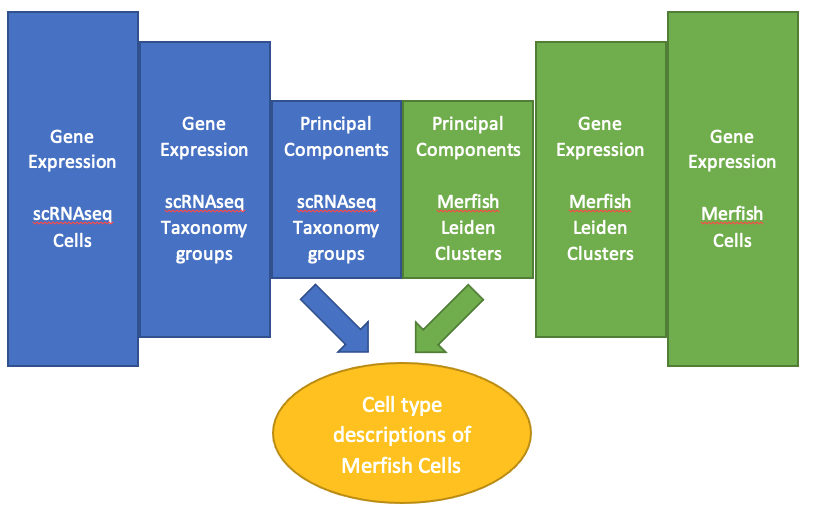

By mapping the list of cells to a higher-order biological entity (taxonomic group / cluster), differences in data collection efficiency and experimental noise are reduced and the underlying gene/cell type information is exposed and can be compared between experiments. These higher-order entities can then be mapped back to individual cells, producing the cell-type annotated spatial maps.


In [ ]:
# files = !ls
# if not any([file for file in files[0].split(" ") if 'l5_all.agg.loom'== file]):
#   %%bash 
#   wget https://storage.googleapis.com/linnarsson-lab-loom/l5_all.agg.loom
# else:
#   print("Already have file")

In [ ]:
import loompy
import pandas as pd

with loompy.connect('/Users/vengeance/Downloads/l5_all.agg.loom') as ds:
  expr = ds[:,:]
  genes = ds.ra.Gene
  clusters = ds.ca.ClusterName
  clust_desc = ds.ca.TaxonomyRank4

# Trim data to genes that are shared by the data sources
gene_match = [g in sig_leiden.index.to_list() for g in genes]
seq_by_clust = pd.DataFrame(expr[gene_match,:], index = genes[gene_match], columns = clusters)
trimmed_merfish = sig_leiden.loc[[m in genes[gene_match] for m in sig_leiden.index]]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import distance

# Fit PCA to scRNAseq Data
x = seq_by_clust.sort_index().T.values
x = StandardScaler().fit_transform(x)

pca = PCA(0.6)
pca.fit(x)
principalComponents = pca.transform(x)
scRNAseq_pca = pd.DataFrame(
    data = principalComponents,
    columns=["PC_" + str(num + 1) for num in range(len(principalComponents[0]))]
)
scRNAseq_pca.index = seq_by_clust.sort_index().T.index
scRNAseq_pca = scRNAseq_pca.T

# Apply PCA to merfish data
x = trimmed_merfish.sort_index().T.values
x = StandardScaler().fit_transform(x)

principalComponents = pca.transform(x)
merfish_pca = pd.DataFrame(
    data = principalComponents,
    columns=["PC_" + str(num + 1) for num in range(len(principalComponents[0]))]
)
merfish_pca.index = trimmed_merfish.sort_index().T.index
merfish_pca = merfish_pca.T

In [ ]:
# Find minimum distance pairs in PCA space (not optimized for performance)
dist_array = []
for merfish_cluster in merfish_pca.columns:
    min_distance = {
        "merfish_cluster": merfish_cluster,
        "scRNAseq_cluster": "NA",
        "distance": 100
    }
    for scRNAseq_cluster in scRNAseq_pca.columns:
        dist = distance.cosine(
            merfish_pca[merfish_cluster].to_list(), 
            scRNAseq_pca[scRNAseq_cluster].to_list(), 
        )
        if dist < min_distance.get("distance"):
            min_distance["scRNAseq_cluster"] = scRNAseq_cluster
            min_distance["distance"] = dist
    dist_array.append(min_distance)
    
# Join data into output table
mapped_PCA_COS_clusters = pd.DataFrame(dist_array).join(
    pd.DataFrame(clust_desc, index = clusters, columns = ["Description"]), on='scRNAseq_cluster'
)

# super_table = meta_leiden.merge(mapped_PCA_COS_clusters, left_on='leiden', right_on='merfish_cluster')
# meta_leiden = super_table[['cell counts','leiden', 'Description']]
# meta_leiden.index = meta_leiden['leiden']

In [ ]:
meta_cluster = mapped_PCA_COS_clusters.set_index('merfish_cluster')
meta_cluster.index.name = None
meta_leiden['Description'] = meta_cluster['Description']

## Hierarchically Cluster Leiden Gene Expressin Data

In [ ]:
meta_gene['info'] = pd.Series('', index=meta_gene.index.tolist())

glial_markers = ['Slc1a2', 'Map1b', 'Dpysl2', 'Kif5c']
meta_gene.loc[glial_markers, 'info'] = 'Glial markers'

gabaergic_genes = ['Gad1', 'Slc32a1']
meta_gene.loc[gabaergic_genes, 'info'] = 'GABAergic markers'

df_colors.loc[''] = 'white'

In [ ]:
net = Network(CGM2)
# net.load_df(sig_leiden, meta_col=meta_leiden, col_cats=['cell counts'])
net.load_df(sig_leiden, meta_col=meta_leiden, col_cats=['leiden', 'Description', 'cell counts'], 
            meta_row=meta_gene, row_cats=['info', 'expression'])
net.filter_threshold(0.01, axis='row')
net.normalize(axis='row', norm_type='zscore')
net.set_global_cat_colors(df_colors)
net.cluster()

#### Code for Observable embed visual

In [ ]:
%%capture
# Collect data for interactive visualization
################################################

cell_by_gene.index = range(len(cell_by_gene.index.tolist()))
gex_int = cell_by_gene.astype(np.int)

gex_dict = {}
for inst_gene in gex_int.columns.tolist():    
    if 'Blank' not in inst_gene:
        ser_gene = gex_int[inst_gene]
        ser_gene = ser_gene[ser_gene > 0]
        ser_gene = ser_gene.astype(np.int8)    
        gex_dict[inst_gene] = ser_gene.to_dict()


df_pos = ad_viz.obs[['center_x', 'center_y', 'leiden']]
df_pos[['center_x', 'center_y']] = df_pos[['center_x', 'center_y']].round(2)
df_pos.columns = ['x', 'y', 'leiden']
df_pos['y'] = -df_pos['y']
df_umap = ad_viz.obsm.to_df()[['X_umap1', 'X_umap2']].round(2)
df_umap.columns = ['umap-x', 'umap-y']

# rotate the mouse brain to the upright position
theta = np.deg2rad(-15)
rot = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])    
df_pos[['x', 'y']] = df_pos[['x', 'y']].dot(rot)

df_name = pd.DataFrame(df_pos.index.tolist(), index=df_pos.index.tolist(), columns=['name'])

df_obs = pd.concat([df_name, df_pos, df_umap], axis=1)
data = df_obs.to_dict('records')

obs_data = {
    'gex_dict': gex_dict,
    'data': data, 
    'cat_colors': cat_colors,
    'network': net.viz    
}

zip_obs_data = json_zip(obs_data)

inputs = {
    'zoom': -3.5, 
    'ini_cat': 'leiden',
    'ini_map_type': 'Spatial',
    'ini_min_radius': 1.75,
    'zip_obs_data': zip_obs_data,
    'gex_opacity_contrast_scale': 0.85
}

## UMAP-Spatial-Heatmap Single-Cell View

Here we visualize Vizgen single-cell gene expression data using an interacive scatterplot and heatmap. On the left, cells can be arranged based on their spatial location in the tissue or based on their dimensionality reduced UMAP embedding. Cells can be colored using their Leiden cluster or the expression of any gene. Genes can be selected from the dropdown above the scatterplot or by clicking a gene row in the interactive heatmap built using [clustergrammer2](https://github.com/ismms-himc/clustergrammer2) and will color cells based on the expression of this gene. The heatmap can also be used to identify genes that are correlated across leiden clusters, as well as the hierarchy of cell-cluster gene expression. This visual enabels users to interactively explore Vizgen's high-dimensional gene expression data and simultaneously observe the spatial locations/morphologies of single-cells in the tissue. The spatial distribution of cell can also be compared to brain mapping projects including the [Allen Brain Atlas](https://portal.brain-map.org/) and [Kim Lab Brain Map](https://kimlab.io/brain-map/atlas/atlas_viewer.html?s=60_AP-1.6&l=81). See below for more in-depth discussion of selected cell-clusters.

 

In [ ]:
embed('@vizgen/umap-spatial-heatmap-single-cell-0-3-0', cells=['viewof cgm', 'dashboard'], inputs=inputs, display_logo=False)

### Ependymal Cluster
Cluster 22 was identified based on gene expression to consist of ependymal cells, which are a specialized glial cell. Among the highly expressed genes are AQP4, Slc25a18, Mlc1, and Gfap which are are known to be expressed in glial cells. This cell type is known to be localized to the sub-ventricular zone and we see this distinct localization in our data. We also observe strikingly similar localization for several of the top expressing genes in this cluster.




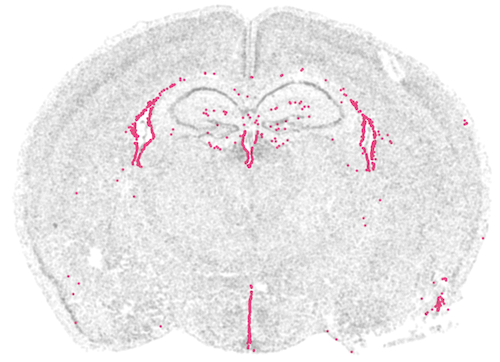

### Inhbitory Cell Cluster
Cluster 24 was identified to consist of inhibitory neurons and this cluster highly expresses Gad1, which produces GABA, and Slc32a1, which packages the GABA for release. While there are many clusters of inhibitory cells, this cluster is distinct based on the expression of the modulatory receptor Cckar and also has a very distinct spatial localization, which is also shared its top expressing genes.

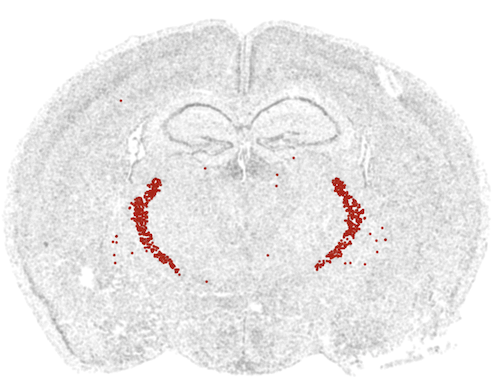